In [18]:
import matplotlib.pyplot as plt
from math import pi, sin, cos, atan, sqrt
import numpy as np
from scipy import interpolate
from scipy.interpolate import lagrange

# Problem 5 - Hermite Interpolation

In [19]:
# Functions from the exercise sheet
def func(x): return sin(x)
def deriv1_func(x): return cos(x)

In [20]:
def createDifferenceTable(f0, f1, pts):
    """ construct a diffrence table. data is structured as follows:

            col0 col1      col2                  col3                            col4      ...
       j ->

    i   0   x0  f0(x0)  (y1 - y0) / (x1 - x0)   (c2[1] - c2[0]) / (x2 - x0)  ...
        1   x0  f0(x0)  (y2 - y1) / (x2 - x1)   ...
    |   2   x1  f1(x1)  (y3 - y2) / (x3 - x2)   ...
    v   3   x1  f1(x1)  (y4 - y3) / (x4 - x3)   (c2[3] - c2[2]) / (x5 - x3)
        4   x2  f2(x2)  (y5 - y4) / (x5 - x4)
        5   x2  f2(x2)

    Note that if any denominator in c[i][j] is 0 the first derivative (f1) is taken instead

    Args:
        f0 (function): base function
        d1 (funtiov): first derivative
        pts (list): lstützstellen

    returns:
        list(list) : difference table
    """   

    diff_table = []    # first column has x values
    col_x, col_fx = [], []
    func_vals = []

    # fill the first two columns
    # col0 = x , col1 = f(x); all entries are included twice
    for x in pts:
        col_x.append(x)
        col_x.append(x)
        col_fx.append(f0(x))
        col_fx.append(f0(x))

    diff_table.append(col_x)
    diff_table.append(col_fx)  

    # fill difference table with remaining columns
    col = []  
    i_max = len(diff_table[0])
    for j in range(1, len(diff_table[0])): 
        col = [] 
        for i in range(i_max - j):
            # calculate denomitor
            x1 = diff_table[0][i+j]
            x0 = diff_table[0][i]
            denominator = float(x1 - x0)

            # add entry depending on the denominator
            if abs(denominator) >= 1e-12: # due to rounding errors a denominator that is 0 evaluates close to zero (i.e.: pi/2 - pi/2)
                # difference quotient
                col.append((diff_table[j][i+1] - diff_table[j][i]) / denominator)
            else:
                # use first derivatice if denominator is close to 0
                col.append(f1(x0))

        diff_table.append(col)  # add new column to difference table

    return diff_table

In [21]:
def hermitePolynome(x, dt):
    """Calculates the value p(x) of the hermite polynom

    Args:
        x (float): independent variable
        dt ([[]]): difference table created by createDifferenceTable()

    Returns:
        float: p(x)
    """    
    p = dt[1][0]

    for i in range(1, len(dt)-1):
        factor = 1  # factor will be (x-x1)(x-x2)(x-x3)...
        for j in range(i):
            factor *= (x - dt[0][j])
        p += dt[i+1][0]*factor
    return p

In [22]:
def convergence_plot(x_pts, approx_vals, analytic_vals):
    assert len(approx_vals) == len(analytic_vals)

    plt.cla()
    plt.plot(x_pts, abs(np.array(approx_vals) - np.array(analytic_vals)))
    plt.title("Convergence if the interpolation")
    plt.yscale("log")
    plt.show()

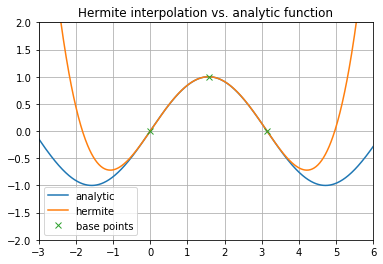

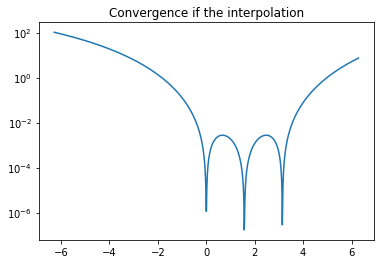

In [23]:
# define x_vals and knots for the interpolations
# note that any number of nots >2 works
knots = np.linspace(0, pi, 3)
x_vals = np.linspace(-2*pi, 2*pi, 1000)

# generate difference table
table = createDifferenceTable(func, deriv1_func, knots)

# calculate functio values for analytical, polynomial and hermite interpolation
hermite_vals =  [ hermitePolynome(x, table) for x in x_vals ]
analytic_vals = [ func(x) for x in x_vals ]
base_vals = [ func(x) for x in knots]

#convergence_plot(x_vals, hermite_vals, analytic_vals)

# plot functions
plt.cla()
plt.plot(x_vals, analytic_vals, label="analytic")
plt.plot(x_vals, hermite_vals, label="hermite")
plt.plot(knots, base_vals, "x", label="base points")
plt.title("Hermite interpolation vs. analytic function")
plt.grid()
plt.legend()
plt.ylim(-2, 2)
plt.xlim(-3, 6)
plt.show()


convergence_plot(x_vals, hermite_vals, analytic_vals)

# Problem 6 - Splines vs. Lagrange

In [24]:
# Functions from Exercise sheet
def f1(x):
    if hasattr(x, "__len__"):
        return [f1(x) for x in x]
    else:
        return sqrt(x)

def f2(x):
    if hasattr(x, "__len__"):
        return [f2(x) for x in x]
    else:
        return atan(10.0*x)

In [25]:
# Lagrane Interpolation as explored in previous exercise
# l_i(x)
def Lagrange (pts, i, x):
    prod = 1
    for j in range(len(pts)):
        if j != i:
            prod = prod * (x-pts[j])/(pts[i]-pts[j])
    return prod

# p(x)
def InterpolationPolynomial (fun, pts, x):
    sum = 0
    for i in range(len(pts)):
        sum = sum + fun(pts[i]) * Lagrange(pts, i, x)
    return sum

In [26]:
# Function for generating Chebyshev Points
def chebyshev_points(count):
    return np.array([cos( (i+0.5)*pi / (count + 1)) for i in range(count)])[::-1] 

def quadratic_points(start, end, count):
    return [x*x for x in np.linspace(start, end, count)]


In [27]:
# creates Plots of the function, cubic interpolation and polynomial interpolation
# also plots the convergence
def compareFunctions(f, f_knots, xMin, xMax, plotPoint_count, name="no Name"):
    xVals = np.linspace(xMin, xMax, plotPoint_count)

    f_analyticVals = f(xVals)

    # Cubic Spline Interpolation
    cubicInterpolation = interpolate.CubicSpline(f_knots, [f(x) for x in f_knots])
    cubic_vals = cubicInterpolation(xVals)

    # Polynomial Interpolation
    poly_interpolation = InterpolationPolynomial(f, f_knots, xVals)

    #calculate errors
    cubic_spline_error = max(abs(f_analyticVals - cubic_vals))
    polynomial_error = max(abs(poly_interpolation - cubic_vals))
    print("Max Error for cubic spline interpolation= " + str(cubic_spline_error))
    print("Max Error for polynomial interpolation= " + str(polynomial_error))



    plt.cla()
    plt.plot(xVals, f_analyticVals, label="analytic")
    plt.plot(xVals, cubic_vals, label="cubic")
    plt.plot(xVals, poly_interpolation, label="polynomial")
    plt.plot(f_knots, f(f_knots), "x", label="interpolated points")
    plt.legend()
    y_max = max(f_analyticVals)
    plt.ylim(-1.1*y_max, 1.1*y_max)
    plt.title(name)
    plt.show()

    # Plot convergence
    plt.cla()
    plt.plot(xVals, abs(f_analyticVals - cubic_vals), label="cubic")
    plt.plot(xVals, abs(f_analyticVals - poly_interpolation), label="polynomial")
    plt.yscale("log")
    plt.legend()
    plt.title("Convergence for " + name)
    plt.show()



In [28]:
# Config
F1_XMIN, F1_XMAX = 0.0, 1.0
F2_XMIN, F2_XMAX = -1.0, 1.0
PLOT_POINT_CNT = 1000
KNOT_CNT = 20

## Linear spaced points for f1

Max Error for cubic spline interpolation= 0.04041634428027736
Max Error for polynomial interpolation= 0.017437772272862098


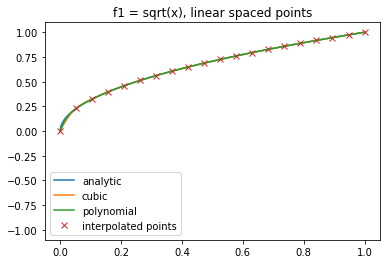

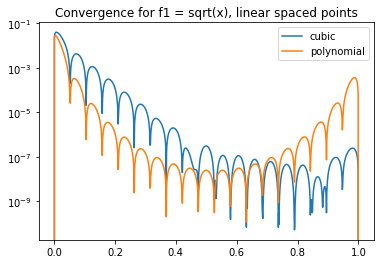

In [29]:
f1_knots = np.linspace(F1_XMIN, F1_XMAX, KNOT_CNT)
compareFunctions(f1, f1_knots, F1_XMIN, F1_XMAX, PLOT_POINT_CNT, "f1 = sqrt(x), linear spaced points")


## Quadratic spaced points for f1

Max Error for cubic spline interpolation= 0.009418280936068488
Max Error for polynomial interpolation= 4217339.190324667


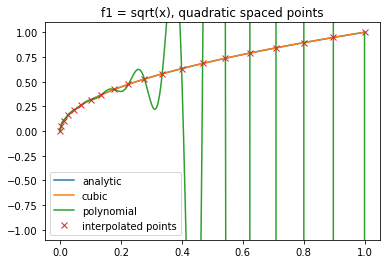

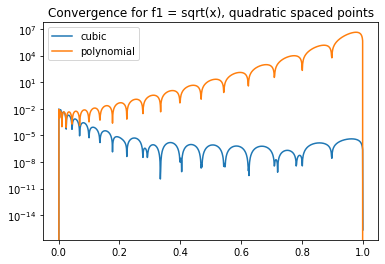

In [30]:
f1_knots = quadratic_points(F1_XMIN, F1_XMAX, KNOT_CNT)
compareFunctions(f1, f1_knots, F1_XMIN, F1_XMAX, PLOT_POINT_CNT, "f1 = sqrt(x), quadratic spaced points")

## Linear spaced points for f2

Max Error for cubic spline interpolation= 0.0024621680560071024
Max Error for polynomial interpolation= 117.45550081452033


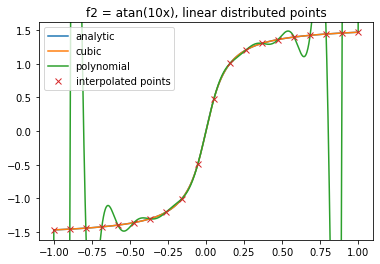

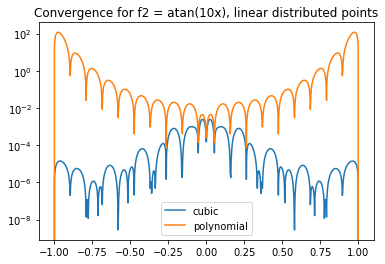

In [31]:
f2_knots = np.linspace(F2_XMIN, F2_XMAX, KNOT_CNT)
compareFunctions(f2, f2_knots, F2_XMIN, F2_XMAX, PLOT_POINT_CNT, "f2 = atan(10x), linear distributed points")

## Chebyshev points for f2

Max Error for cubic spline interpolation= 0.08504092535497532
Max Error for polynomial interpolation= 0.01748052585241333


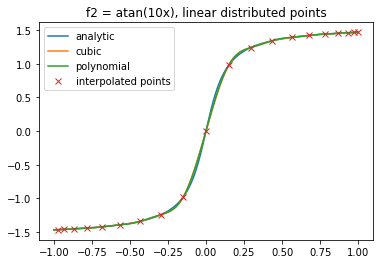

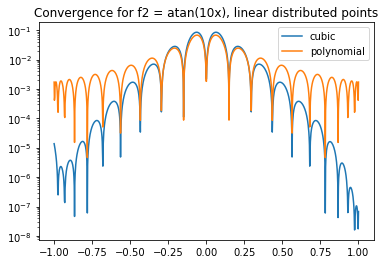

In [32]:
f2_knots = chebyshev_points(KNOT_CNT)
compareFunctions(f2, f2_knots, F2_XMIN, F2_XMAX, PLOT_POINT_CNT, "f2 = atan(10x), linear distributed points")

# Problem 7 - Extrapolation of infinite Series 

In [33]:
def g(x):
    if hasattr(x, "__len__"): return [g(x) for x in x]
    else: return sum([6.0 / (j*j) for j in range(1, 1+int(round(1/x, 0)))])

def generate_knots(count):
     return [2**(-i) for i in range(count)]

p(0) = 9.869604401089337
π² = 9.869604401089358
Error = 2.1316282072803006e-14


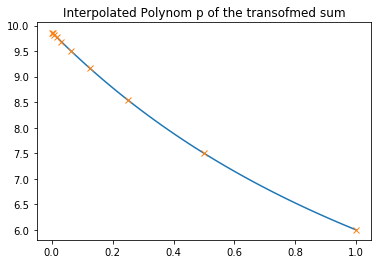

In [34]:
knots = generate_knots(10)
poly = lagrange(knots, g(knots))
p0 = poly(0)


x_vals = np.linspace(0,1,100)
y = [poly(x) for x in x_vals]
plt.plot(x_vals, y)
plt.title("Interpolated Polynom p of the transofmed sum")
plt.plot(knots, g(knots), "x")

print("p(0) = " + str(p0))
print("π² = " + str(pi*pi))
print("Error = " + str(abs(p0 - pi*pi)))
